# Cloudflare Data Analysis

In [38]:
import pandas as pd
from sqlalchemy import create_engine
import json
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import ast
import duckdb
import time
import pycountry
from datetime import datetime, timedelta, date
from calendar import monthrange
from calendar import day_name
from matplotlib.pyplot import figure
from math import inf

def country_name(country_iso):
    return pycountry.countries.get(alpha_2=country_iso).name

def filter_for(df, name, value):
    return df.loc[df[name] == value]

def filter_for_unequal(df, name, value):
    return df.loc[df[name] != value]

def filter_for_range(df, name, lower_bound, upper_bound):
    return df[(df[name] >= lower_bound) & (df[name] < upper_bound)]

def days_in_month(year, month):
    return monthrange(year, month)[1]

def first_weekday_of_month(year, month):
    return monthrange(year, month)[0]

def date_to_weekday(day, month, year):
    date = datetime(year, month, day)
    return day_name[date.weekday()]

def to_latex(df, columns=None, label="nolabel", caption="notitle"):
    if not columns:
        columns = df.columns.tolist()
    return df.to_latex(index=True, bold_rows=True, label=label, caption=caption, columns=columns)

In [13]:
data = duckdb.read_parquet('./parquet/ping_data.parquet')
df = duckdb.sql("SELECT * FROM data WHERE source_platform = 'Cloudflare RADAR (timeseries groups)' and result NOT LIKE '%p25%null%p50%null%p75%null%' ORDER BY timestamp;").to_df().drop(columns=['msm_id', 'destination', 'source', 'country', 'prb_id', 'sent_packets', 'received_packets', 'source_platform'])

In [14]:
df

,result,timestamp,msm_type,step
0,"""{\""p25\"":\""5.864718\"",\""p50\"":\""6.663875\"",\""...",1711929600000,ping,900
1,"""{\""p25\"":\""5.864718\"",\""p50\"":\""6.663875\"",\""...",1711929600000,ping,900
2,"""{\""p25\"":\""13.204957\"",\""p50\"":\""16.924309\"",...",1711930500000,ping,900
3,"""{\""p25\"":\""17.20167\"",\""p50\"":\""21.556765\"",\...",1711931400000,ping,900
4,"""{\""p25\"":\""22.241683\"",\""p50\"":\""26.596778\"",...",1711932300000,ping,900
...,...,...,...,...
5680,"""{\""p25\"":\""97.046585\"",\""p50\"":\""116.040348\""...",1717186500000,ping,900
5681,"""{\""p25\"":\""89.931083\"",\""p50\"":\""107.442683\""...",1717187400000,ping,900
5682,"""{\""p25\"":\""90.531196\"",\""p50\"":\""107.075095\""...",1717188300000,ping,900
5683,"""{\""p25\"":\""94.38492\"",\""p50\"":\""113.932887\"",...",1717189200000,ping,900


In [11]:
latencies = []
timestamps = []

results = df['result'].tolist()
df_timestamps = df['timestamp'].tolist()

i = 0
for result in results:
    try:
        dict = ast.literal_eval(json.loads(result)) 
        latencies.append([float(dict['p25']), float(dict['p50']), float(dict['p75'])])
        timestamps.append(float(df_timestamps[i]))
    except:
        latencies.append([0.0,0.0,0.0])
        timestamps.append(float(df_timestamps[i]))
    i += 1

assert len(latencies) == len(timestamps)

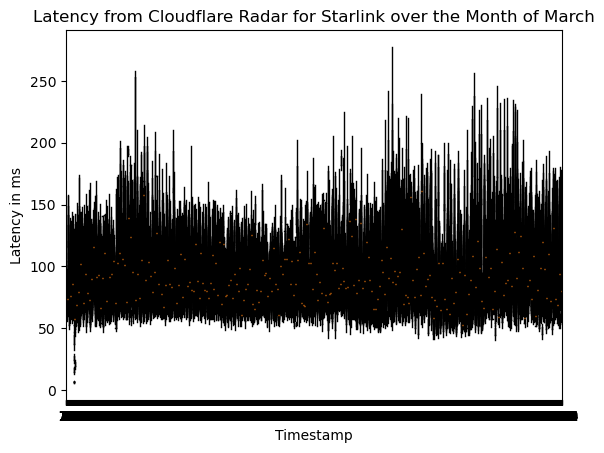

In [12]:
fig, ax = plt.subplots()
plt.xticks([],[])

plt.ylabel('Latency in ms')
plt.xlabel('Timestamp')
plt.title('Latency from Cloudflare Radar for Starlink over the whole time range')
plt.boxplot(latencies)
plt.show()

The latency is very unstable. Why? Can we observe change over the day?

Lets look at the first three days of March.

93


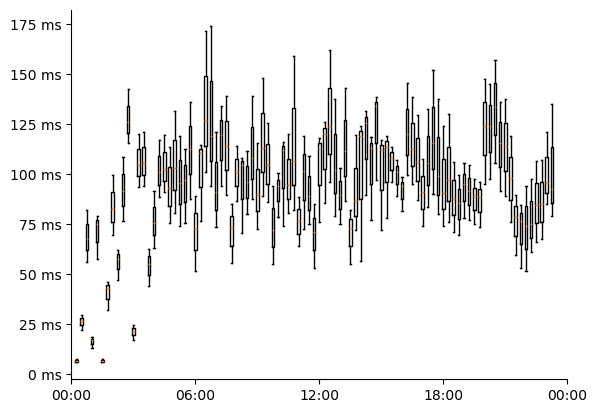

93


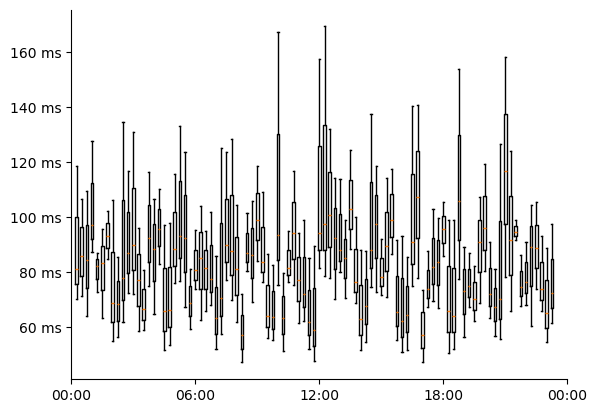

95


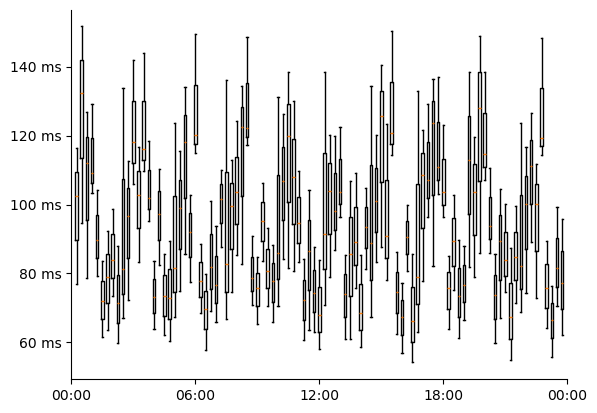

95


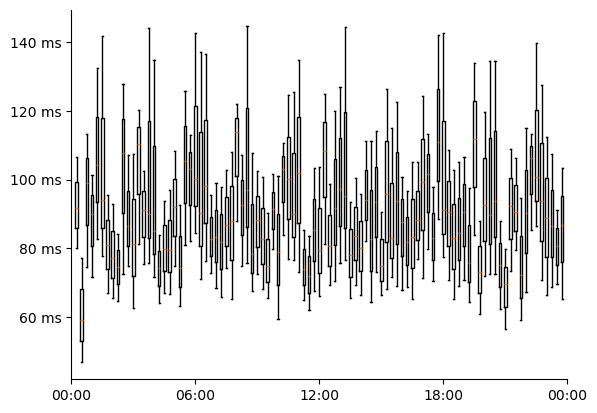

0


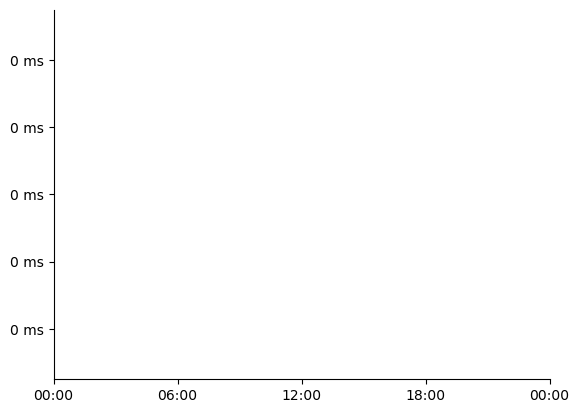

281


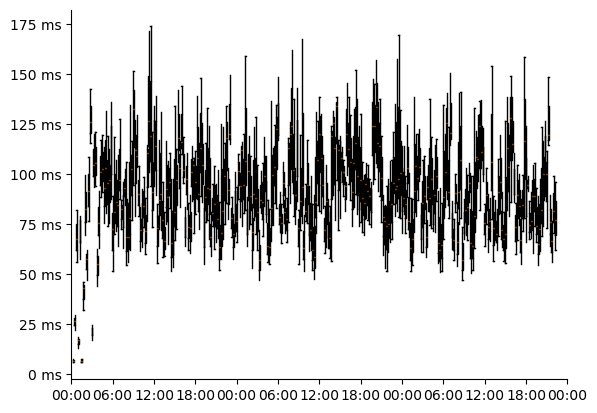

658


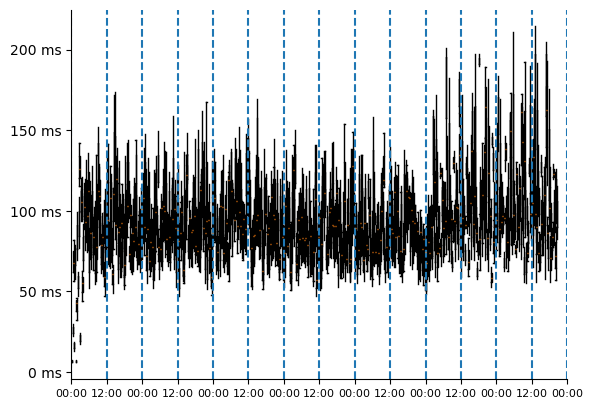

666


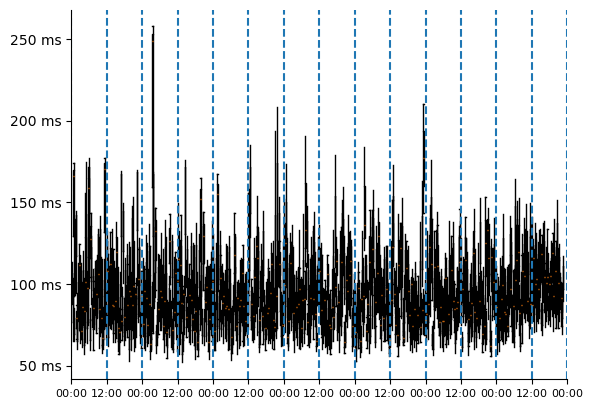

663


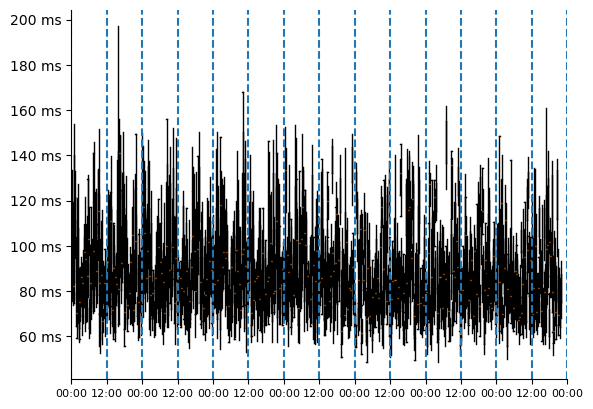

655


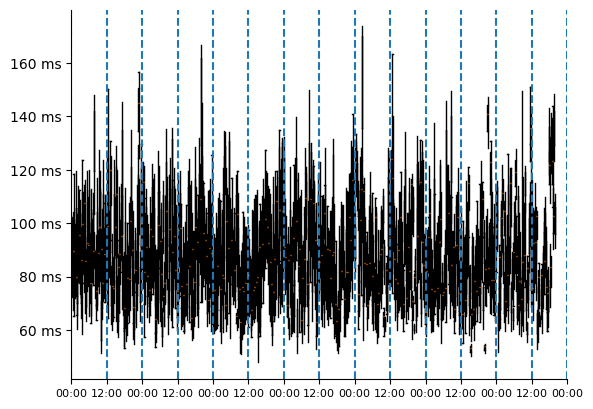

In [39]:
def plot_day(start, end, no_days=1):
    short_latencies = []
    short_timestamps = []
    STOP = time.mktime(datetime.fromisoformat(end).timetuple()) * 1000
    START = time.mktime(datetime.fromisoformat(start).timetuple()) * 1000

    for i in range(0, len(timestamps)):
        if timestamps[i] < STOP and timestamps[i] >= START:
            short_latencies.append(latencies[i])
            short_timestamps.append(timestamps[i])
    print(len(short_latencies))
    
    fig, ax = plt.subplots()
    ax.boxplot(short_latencies)
    if (no_days < 4):
        plt.xticks([24 * i for i in range(0, 1 + (no_days) * 4)], ['0' + str(int(((24*i) % 96) / 4)) + ':00' if (((24*i) % 96) / 4) < 10 else str(int(((24*i) % 96) / 4)) + ':00' for i in range(0, 1 + (no_days) * 4)])
    else:
        positions = [48 * i for i in range(0, 1 + (no_days) * 2)]    
        labels = ['0' + str(int(((48*i) % 96) / 2)) + ':00' if (((48*i) % 96) / 4) < 10 else str(int(((48*i) % 96) / 4)) + ':00' for i in range(0, 1 + (no_days) * 2)]
        plt.xticks(positions, labels, fontsize=8)
        #for pos in positions: plt.axvline(x=pos, ls='--')

    ax.spines[['right', 'top']].set_visible(False)

    def fmt(x, pos):
        return f'{int(x)} ms'
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
    plt.savefig(f'cloudflare/cf_radar_latencies_{start[0:10]}_{end[0:10]}.pdf')
    plt.show()

plot_day('2024-04-01T00:00:00Z', '2024-04-02T00:00:00Z')
plot_day('2024-04-02T00:00:00Z', '2024-04-03T00:00:00Z')
plot_day('2024-04-03T00:00:00Z', '2024-04-04T00:00:00Z')
plot_day('2024-04-04T00:00:00Z', '2024-04-05T00:00:00Z')
plot_day('2024-04-05T00:00:00Z', '2024-04-04T00:00:00Z')
plot_day('2024-04-01T00:00:00Z', '2024-04-04T00:00:00Z', no_days=3)
plot_day('2024-04-01T00:00:00Z', '2024-04-08T00:00:00Z', no_days=7)
plot_day('2024-04-08T00:00:00Z', '2024-04-15T00:00:00Z', no_days=7)
plot_day('2024-04-15T00:00:00Z', '2024-04-22T00:00:00Z', no_days=7)
plot_day('2024-04-22T00:00:00Z', '2024-04-29T00:00:00Z', no_days=7)